In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math as math
import pandas as pd
from scipy.integrate import simps
from scipy.integrate import odeint


'__Fuente de gráficos__'
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = '9'


'__Datos Cinéticos Experimentales'
tiempo_experimental = [1,5,10,15,30,46,80,108,142,168,192,1263,1608]                             # min
concentracion_experimental = [0.11,0.21,0.3,0.46,0.72,0.93,1.3,1.37,1.59,1.62,1.58,1.64,1.76]    # g/L
datos_experimentales = [[tiempo_experimental],[concentracion_experimental]]


'__Constantes__'
kb = 1.38*10**-23
pi = np.pi


'__Estimación viscosidades__'
T = 25 + 273


'__Definición de propiedades__'
porcentajeAC = 0.06
dens = 557.82
densb = 180
densL = 935.69
Deff = (1.3*(10**-10))/60       
phi = 2.012453362               # Factor de forma
a = 0.000706498099              # Longitud característica
ap = 3.362*10**3                # Área equivalente
Deq = 6/ap


'__Propiedades estimadas__'
viscH2O = math.e**(-52.843 + 3703.6/T + 5.866*math.log(T) - 5.98*10**(-29)*(T)**10)     # Viscosidad del agua
viscEtOH = math.e**(7.875+781.98/T -3.0418*math.log(T))                                 # Viscosidad del etanol
visc = 0.01                                                                             # Viscosidad de la mezcla
rad = math.pow(326.5*(3./(4.*math.pi)), 1./3.)                                          # radio molecular de van der waals
Dab = kb*T/(6*math.pi*visc*rad)                                                         # Ecuación de Einstein para difusividad


'__Definición de parámetros de diseño__'
eps = 1.-densb/dens     # Porosidad del lecho
L = 4.421               # Longitud del equipo
Dc = 0.2                # Diámetro del equipo
A = math.pi*(Dc/2)**2   # Área del equipo
S = 1.072*10**-6        # Flujo volumétrico de sólidos (m³/s)
nu = 2.249*10**-6       # Flujo volumétrico de solvente (m³/s)
tau = 4*3600            # Tiempo máximo a calcular en la simulación


'__Estimación de parámetros__'
uz = nu/(A)                                         # Velocidad lineal de solvente
Re = uz*Deq*densL/(visc*eps)                        # Número de Reynolds
Pe = 0.2/eps + 0.011/eps + math.pow(eps*Re, 0.48)   # Número de Peclet
Sc = visc/(densL*Dab)                               # Numero de Schmidt
Sh = 2+1.1*math.pow(Sc, 0.33)*math.pow(Re, 0.6)     # Número de Sherwood
Dax = Deq*uz/(eps*Pe)                               # Dispersión axial
kL = Sh*Dab/a                                       # Transferencia de masa en fase líquida


'__Definición de la constante global de transferencia de masa__'
K = 8.07*10**-9
K = K*ap




'__Definición de funciones__'
def find_nearest(array, value):
    '''
    Recibe un array y un valor; devuelve el valor más cercano al recibido
    '''
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return array[idx-1]
    else:
        return array[idx]

def find_nearest_pos(array, value):
    '''
    Recibe un array y un valor; devuelve el índice del elemento con el valor más cercano al recibido
    '''
    idx = np.searchsorted(array, value, side="right")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return idx-1
    else:
        return idx

# Función de equilibrio
def eqX(y):
    '''
    Devuelve concentración de equilibrio en fase sólida a partir de una concentración en fase líquida
    '''
    KeqX = [15.80011045, 32.02907632, 5.735438305, 0.053726466, 1.972131456]
    eqX = KeqX[0]*KeqX[1]*y/(1+KeqX[1]*y)+KeqX[2] * \
        KeqX[3]*(y-KeqX[4])/(1-KeqX[3]*(y-KeqX[4]))
    return eqX

# Funciones de transferencia de masa
def batch(X, t):
    '''
    '''
    x = X[0]
    y = X[1]
    dxdt = K * (eqX(y)-x) / (1-eps)
    dydt = -K * (eqX(y) - x) / eps
    return [dxdt, dydt]

def error_porcentual(modelo):

    error_porcentual = 0

    for i, dato in enumerate(concentracion_experimental):

        tiempo = tiempo_experimental[i]
        posicion_t = find_nearest_pos(t/60,tiempo)
        
        error = abs((modelo[posicion_t, 1]-dato)/dato)
        error_porcentual += error

    return error_porcentual/(i+1)*100

### Ajuste de K y comparación de datos experimentales con modelo

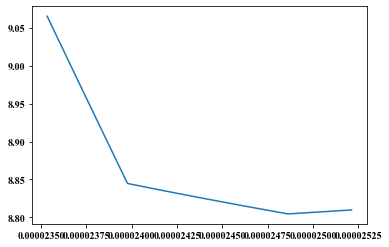

Mínimo error porcentual: 8.804404231646746 con Ka = 2.486199e-05


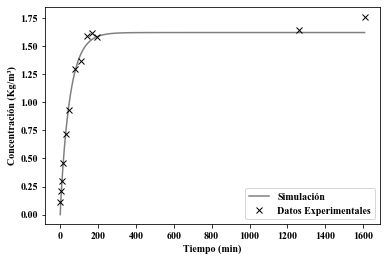

In [2]:
eps = 0.9177
t = np.linspace(0,tiempo_experimental[-1]*60,100000)

x0=porcentajeAC*dens
y0=0

mat_Ka = np.array([])
mat_error = np.array([])
sol = odeint(batch,[x0,y0],t)

for K in range(7000,7500):
    K = K*10**-12*ap
    sol = odeint(batch,[x0,y0],t)
    error = error_porcentual(sol)
    mat_Ka = np.append(mat_Ka, K)
    mat_error = np.append(mat_error, error)
plt.plot(mat_Ka,mat_error)
plt.show()

# Defino K como el que dio el mínimo error cuadrado
K = float(mat_Ka[np.where(mat_error == mat_error.min())])
print(f'Mínimo error porcentual: {mat_error.min()} con Ka = {K}')

# Grafico
plt.plot(t/60, sol[:,1], label="Simulación",color='grey')
plt.plot(tiempo_experimental, concentracion_experimental, marker='x',linestyle=' ', label='Datos Experimentales', color='black')
plt.xlabel('Tiempo (min)')
plt.ylabel('Concentración (Kg/m³)')
plt.legend()
plt.show()

### Calculo de batchs variando densidad de lecho

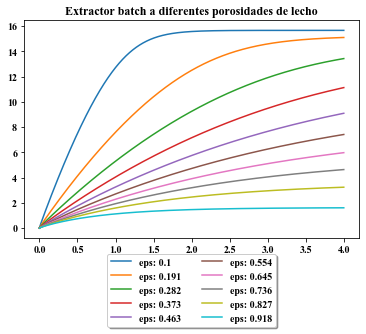

Rendimiento a eps:0.1 -> 0.052
Rendimiento a eps:0.191 -> 0.106
Rendimiento a eps:0.282 -> 0.157
Rendimiento a eps:0.373 -> 0.197
Rendimiento a eps:0.463 -> 0.235
Rendimiento a eps:0.554 -> 0.275
Rendimiento a eps:0.645 -> 0.324
Rendimiento a eps:0.736 -> 0.386
Rendimiento a eps:0.827 -> 0.462
Rendimiento a eps:0.918 -> 0.535


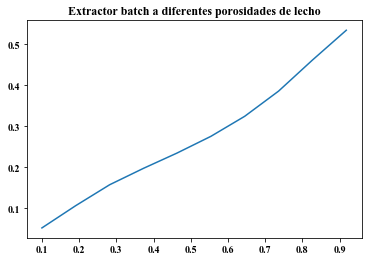

In [10]:
soluciones = []
epsilons = np.linspace(0.1,0.9177,10)
for eps in epsilons:

    nt = 10000
    t = np.linspace(0,tau, nt)
    x0 = porcentajeAC*dens
    y0 = 0
    soluciones.append([eps,odeint(batch, [x0,y0], t)])

t = t/3600

for sol in soluciones:
    plt.plot(t, sol[1][:,1],label=f"eps: {round(sol[0],3)}")

plt.title("Extractor batch a diferentes porosidades de lecho")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), shadow=True, ncol=2)
plt.show()
rendimientos = []

for sol in soluciones:
    rendimiento = 1-sol[1][-1][0]/sol[1][0][0]
    rendimientos.append(rendimiento)
    print(f'Rendimiento a eps:{round(sol[0],3)} -> {round(1-sol[1][-1][0]/sol[1][0][0],3)}')

plt.plot(np.round(epsilons,3),rendimientos)
plt.title("Extractor batch a diferentes porosidades de lecho")
plt.show()

### Calculo de tres batchs en serie

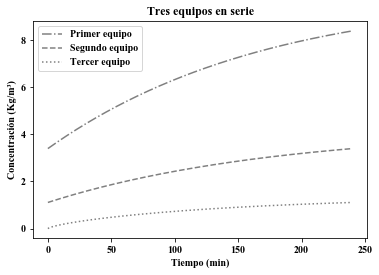


Concentración final con un equipo: 5.494916302528948
Concentración final con tres equipos: 8.381478937704848
Mejora Porcentual con tres equipos: 52.531512333452774



In [8]:
eps = 1.-densb/dens
t = np.linspace(0,tau, nt)
sol0 = odeint(batch,[x0,y0],t)
sol1 = odeint(batch, [sol0[-1][0],y0], t)
sol2 = odeint(batch, [sol1[-1][0],y0], t)
sol3 = odeint(batch, [sol2[-1][0],y0], t)

lista = []

for i in range(0,10):
    sol1 = odeint(batch, [x0, sol2[-1][1]], t)
    sol2 = odeint(batch, [sol1[-1][0], sol3[-1][1]], t)
    sol3 = odeint(batch, [sol2[-1][0], y0], t)
    lista.append(sol3[-1][1])

plt.plot(t/60, sol1[:,-1], ls='-.', color='grey', label = 'Primer equipo')
plt.plot(t/60, sol2[:,-1], ls='--', color='grey', label = 'Segundo equipo')
plt.plot(t/60, sol3[:,-1], ls=':', color='grey', label = 'Tercer equipo')
plt.title('Tres equipos en serie')
plt.xlabel('Tiempo (min)')
plt.ylabel('Concentración (Kg/m³)')
plt.legend()
plt.show()


print(f'''
Concentración final con un equipo: {sol0[-1][1]}
Concentración final con tres equipos: {sol1[-1][1]}
Mejora Porcentual con tres equipos: {100*(sol1[-1][1]-sol0[-1][1])/sol0[-1][1]}
''')

### Calculo de dos batchs en serie

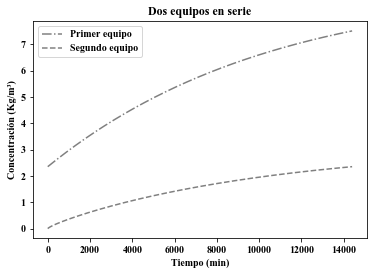

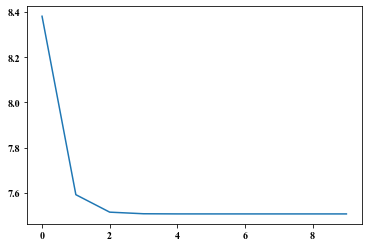


Concentración final con dos equipos: 7.506315549774639
Rendimiento con dos equipos: 47.075389725608964
Mejora Porcentual con dos equipos: 36.60472947185705



In [5]:
convergencia = []

for i in range(0,10):
    sol1 = odeint(batch, [x0, sol2[-1][1]], t)
    sol2 = odeint(batch, [sol1[-1][0], y0], t)
    convergencia.append(sol1[-1][1])

conc_final_2 = sol1[-1][-1]
rendimiento_2 = (sol1[0][0]-sol2[-1][0])/sol1[0][0]*100

# Fase Líquida
plt.plot(t, sol1[:,-1], ls='-.', color='grey', label = 'Primer equipo')
plt.plot(t, sol2[:,-1], ls='--', color='grey', label = 'Segundo equipo')

plt.title('Dos equipos en serie')
plt.xlabel('Tiempo (min)')
plt.ylabel('Concentración (Kg/m³)')
plt.legend()
plt.show()

plt.plot(convergencia)
plt.show()

print(f'''
Concentración final con dos equipos: {conc_final_2}
Rendimiento con dos equipos: {rendimiento_2}
Mejora Porcentual con dos equipos: {100*(sol1[-1][1]-sol0[-1][1])/sol0[-1][1]}
''')